In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from affinewarp.datasets import jittered_data

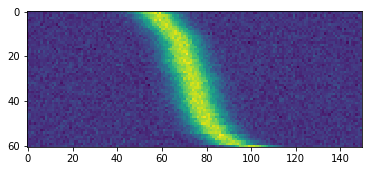

In [3]:
data = jittered_data(t=np.linspace(-8,8,150))[-1]

plt.imshow(np.squeeze(data))

In [4]:
from affinewarp import ShiftWarping

model = ShiftWarping(maxlag=.2, shift_penalty=0)
model.fit(data, iterations=10)

Loss: 4.83: 100%|██████████| 10/10 [00:00<00:00, 14.93it/s]


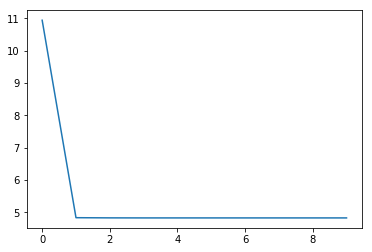

In [5]:
plt.plot(model.loss_hist)

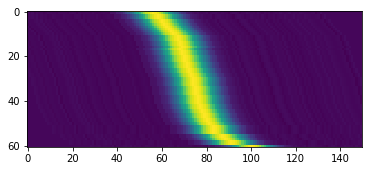

In [6]:
plt.imshow(model.predict().squeeze())

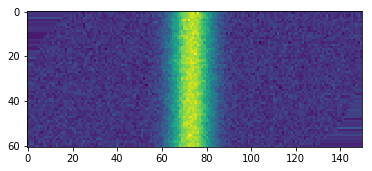

In [7]:
plt.imshow(model.transform(data).squeeze())

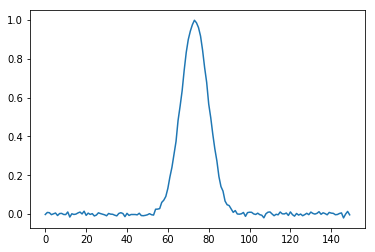

In [8]:
plt.plot(model.template)

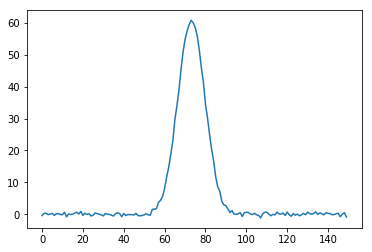

In [9]:
plt.plot(model.WtX)

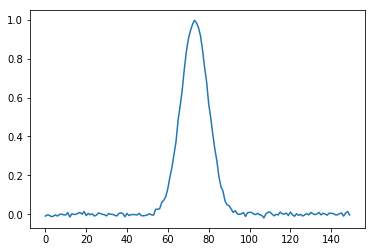

In [10]:
plt.plot(model.transform(data)[:,:,0].mean(axis=0))

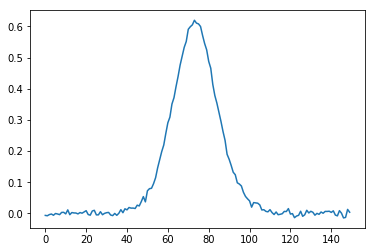

In [11]:
plt.plot(data.mean(axis=0))